In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import collections

import numpy as np
import random
import sklearn.datasets as dt

import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
import tensorflow_federated as tff
from sklearn.utils import shuffle

from tensorflow.keras import layers
from tensorflow.keras import activations

import math

tff.backends.reference.set_reference_context()

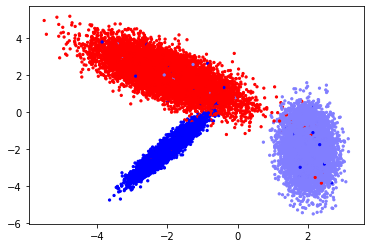

In [3]:
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

x,y = dt.make_classification(n_samples=30000,
                                 n_features=2,
                                 n_repeated=0,
                                 class_sep=2,
                                 n_redundant=0,
                                 n_classes=3,
                                 n_clusters_per_class=1,
                                 random_state=1000)


my_scatter_plot = plt.scatter(x[:,0],
                                  x[:,1],
                                  c=y,
                                  vmin=min(y),
                                  vmax=max(y),
                                  s=5,
                                  cmap=color_map_discrete)

plt.show()

In [4]:
print(type(x))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [5]:
y.tolist().count(0)

10000

In [6]:
y.tolist().count(1)

9995

In [7]:
y.tolist().count(2)

10005

In [8]:
list0 = []
list1 = []
list2 = []

for a,b in zip(x,y):
    c = a.tolist()
    c.append(b)
    if b == 0:
        list0.append(c)
    elif b == 1:
        list1.append(c)
    else:
        list2.append(c)

In [9]:
client1 = []
client2 = []
client3 = []

l01 = math.ceil(len(list0)*0.7)
l02 = math.ceil(len(list0)*0.8)

l11 = math.ceil(len(list0)*0.6)
l12 = math.ceil(len(list0)*0.75)

l21 = math.ceil(len(list0)*0.65)
l22 = math.ceil(len(list0)*0.85)


client1 = list0[:l01] + list1[l11:l12] + list2[l22:]


client2 = list0[l02:] + list1[:l11] + list2[l21:l22]


client3 = list0[l01:l02] + list1[l12:] + list2[:l21]

In [10]:
random.shuffle(client1)
random.shuffle(client2)
random.shuffle(client3)

In [11]:
NUM_EXAMPLES_PER_USER = 1000
BATCH_SIZE = 100
NUM_OF_CLIENTS = 3

In [12]:
BATCH_SPEC = collections.OrderedDict(
    x=tf.TensorSpec(shape=[None, 2], dtype=tf.float32),
    y=tf.TensorSpec(shape=[None], dtype=tf.int32))
BATCH_TYPE = tff.to_type(BATCH_SPEC)

str(BATCH_TYPE)

'<x=float32[?,2],y=int32[?]>'

In [13]:
LOCAL_DATA_TYPE = tff.SequenceType(BATCH_TYPE)

str(LOCAL_DATA_TYPE)

'<x=float32[?,2],y=int32[?]>*'

In [14]:
MODEL_SPEC = collections.OrderedDict(
    weights=tf.TensorSpec(shape=[2, 3], dtype=tf.float32),
    bias=tf.TensorSpec(shape=[3], dtype=tf.float32))
MODEL_TYPE = tff.to_type(MODEL_SPEC)

print(MODEL_TYPE)

<weights=float32[2,3],bias=float32[3]>


In [15]:
SERVER_MODEL_TYPE = tff.FederatedType(MODEL_TYPE, tff.SERVER)
CLIENT_DATA_TYPE = tff.FederatedType(LOCAL_DATA_TYPE, tff.CLIENTS)

In [16]:
WEIGHT_SPEC = tff.TensorType(
    dtype=tf.float32, shape=[1]
)
WEIGHT_TYPE = tff.to_type(WEIGHT_SPEC)
WEIGHT_DATA_TYPE = tff.FederatedType(WEIGHT_TYPE, tff.CLIENTS)

# CLIENT

In [17]:
@tf.function
def forward_pass(model, batch):
    predicted_y = tf.nn.softmax(tf.matmul(batch['x'], model['weights']) + model['bias'])
    return -tf.reduce_mean(
        tf.reduce_sum(
            tf.one_hot(batch['y'], 3) * tf.math.log(predicted_y), axis=[1]))

@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)
def batch_loss(model, batch):
    return forward_pass(model, batch)

In [18]:
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE, tf.float32)
def batch_train(initial_model, batch, learning_rate):
    model_vars = collections.OrderedDict([
        (name, tf.Variable(name=name, initial_value=value))
        for name, value in initial_model.items()
    ])
    optimizer = tf.keras.optimizers.SGD(learning_rate)
    
    @tf.function
    def _train_on_batch(model_vars, batch):
        # Perform one step of gradient descent using loss from `batch_loss`.
        with tf.GradientTape() as tape:
            loss = forward_pass(model_vars, batch)
        grads = tape.gradient(loss, model_vars)
        optimizer.apply_gradients(zip(tf.nest.flatten(grads), tf.nest.flatten(model_vars)))
        return model_vars
  
    return _train_on_batch(model_vars, batch)

In [19]:
LOCAL_DATA_TYPE = tff.SequenceType(BATCH_TYPE)

@tff.federated_computation(MODEL_TYPE, tf.float32, LOCAL_DATA_TYPE)
def local_train(initial_model, learning_rate, all_batches):
    
    # Mapping function to apply to each batch.
    @tff.federated_computation(MODEL_TYPE, BATCH_TYPE)
    def batch_fn(model, batch):
        return batch_train(model, batch, learning_rate)
    return tff.sequence_reduce(all_batches, initial_model, batch_fn)

# SERVER

In [20]:
@tff.federated_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
def local_eval(model, all_batches):
    return tff.sequence_sum(
        tff.sequence_map(
            tff.federated_computation(lambda b: batch_loss(model, b), BATCH_TYPE),all_batches))

In [21]:
@tff.federated_computation(SERVER_MODEL_TYPE, CLIENT_DATA_TYPE)
def federated_eval(model, data):
    return tff.federated_mean(tff.federated_map(local_eval, [tff.federated_broadcast(model), data]))

In [22]:
SERVER_FLOAT_TYPE = tff.FederatedType(tf.float32, tff.SERVER)


@tff.federated_computation(SERVER_MODEL_TYPE, SERVER_FLOAT_TYPE,
                           CLIENT_DATA_TYPE)
def federated_train(model, learning_rate, data):
    return tff.federated_mean(tff.federated_map(local_train, [
            tff.federated_broadcast(model),
             tff.federated_broadcast(learning_rate), data
        ]))

In [23]:
initial_model = collections.OrderedDict(
    weights=np.zeros([2, 3], dtype=np.float32),
    bias=np.zeros([3], dtype=np.float32))

In [27]:
def modelR(weights, biases, data):
    count = 0
    avg = 0
    for j in range(len(federated_test_data[0])):
        l = [np.where(i==max(i))[0][0] for i in activations.sigmoid(np.matmul(federated_test_data[0][j].get('x'), model.get('weights'))).numpy()]
        Y = federated_test_data[0][j].get('y')
        
        for i in range(len(Y)):
            avg+=1
            if l[i] == Y[i]:
                count+= 1
    return count/avg 